In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import pickle

In [2]:
data = pd.read_csv('data.txt', sep=",")

print(data.head())

    User          Movie Rating
0  Alice      Star Wars      5
1  Frank  The Godfather      4
2    Bob        Titanic      5
3  Carol     The Matrix      3
4   Dave      Inception      2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   User    58 non-null     object
 1   Movie   58 non-null     object
 2   Rating  55 non-null     object
dtypes: object(3)
memory usage: 1.5+ KB


In [4]:
print(data['Rating'])

0        5
1        4
2        5
3        3
4        2
5        4
6        5
7        2
8        3
9        4
10       4
11       5
12       4
13       5
14       3
15       5
16       4
17       5
18       3
19       4
20       4
21       1
22       4
23       5
24       3
25       5
26       3
27       3
28       4
29       5
30       5
31       4
32      5x
33    Five
34       5
35       2
36       4
37       4
38       2
39       4
40     NaN
41     NaN
42       4
43     3.5
44       5
45       x
46     3.5
47       5
48      5y
49     3.5
50      2?
51     NaN
52       4
53       5
54       3
55       3
56       5
57       4
Name: Rating, dtype: object


In [5]:
# Convert the 'Rating' column to numeric, setting errors='coerce' to turn invalid parsing into NaN
data['Rating'] = pd.to_numeric(data['Rating'], errors='coerce')

In [6]:
# Drop NA values
data.dropna(subset=['Rating'], inplace=True)

In [7]:
# General Overview
print("General Overview:")
print(data.describe())
print(data.info())
print("\n")


General Overview:
          Rating
count  50.000000
mean    3.890000
std     1.011616
min     1.000000
25%     3.000000
50%     4.000000
75%     5.000000
max     5.000000
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 57
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   User    50 non-null     object 
 1   Movie   50 non-null     object 
 2   Rating  50 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.6+ KB
None




In [8]:
# User Analysis
print("User Analysis:")
user_ratings = data.groupby('User')['Rating'].mean().sort_values(ascending=False)
print(user_ratings)
print("\n")

User Analysis:
User
Xander    5.000000
Uma       5.000000
Alice     4.000000
Karen     4.000000
Sarah     4.000000
Quincy    4.000000
Nina      4.000000
Mia       4.000000
Ivy       4.000000
Frank     4.000000
Emily     4.000000
Carol     4.000000
Wendy     3.750000
Leo       3.666667
Bob       3.666667
Oscar     3.666667
Dave      3.666667
Zane      3.666667
Paul      3.333333
Name: Rating, dtype: float64




In [9]:
# Movie Analysis
print("Movie Analysis:")
movie_ratings = data.groupby('Movie')['Rating'].mean().sort_values(ascending=False)
print(movie_ratings)
print("\n")


Movie Analysis:
Movie
The Godfather    4.500000
Star Wars        4.428571
Titanic          4.400000
Forrest Gump     3.944444
Pulp Fiction     3.642857
The Matrix       3.642857
Inception        3.111111
Name: Rating, dtype: float64




Ratings Distribution:


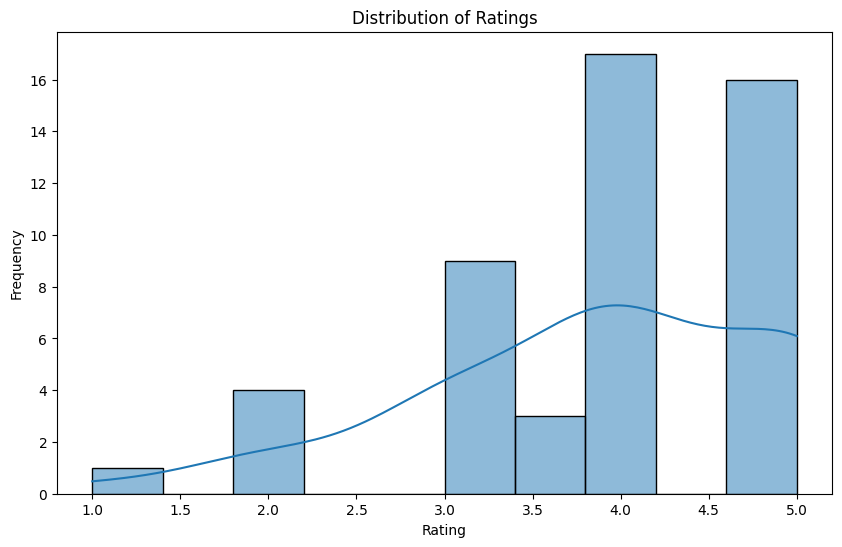

In [10]:
# Ratings Analysis
print("Ratings Distribution:")
plt.figure(figsize=(10, 6))
sns.histplot(data['Rating'], kde=True, bins=10)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Most Rated Movies:


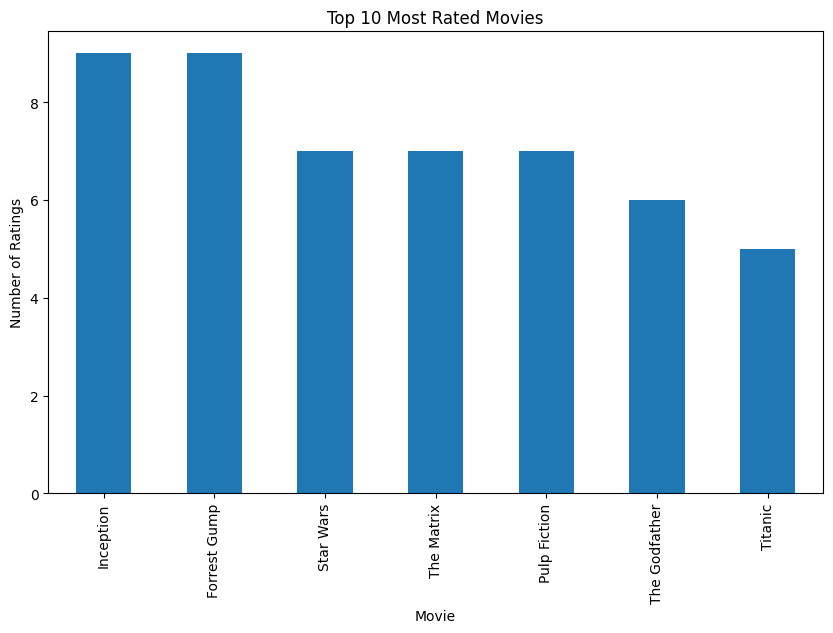

In [11]:
# Most Rated Movies
print("Most Rated Movies:")
most_rated = data['Movie'].value_counts().head(10)
most_rated.plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Movie')
plt.ylabel('Number of Ratings')
plt.show()

Rating Count per User:


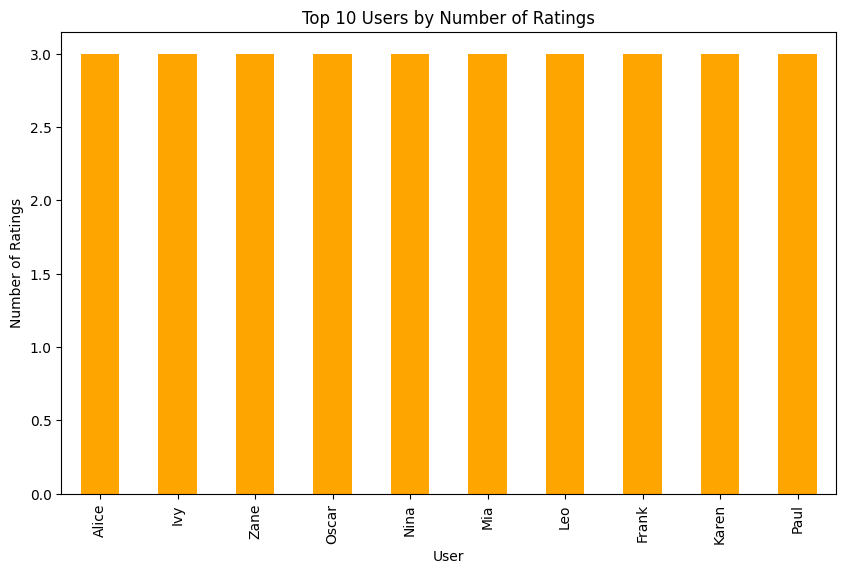

In [12]:
# Rating Count per User
print("Rating Count per User:")
user_rating_count = data['User'].value_counts().head(10)
user_rating_count.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Top 10 Users by Number of Ratings')
plt.xlabel('User')
plt.ylabel('Number of Ratings')
plt.show()

In [13]:
# Create a pivot table
movie_matrix = data.pivot_table(index='User', columns='Movie', values='Rating')

# Transpose the matrix to compute item-item similarity
movie_matrix_transposed = movie_matrix.T

# Compute cosine similarity between items (movies)
cosine_sim = cosine_similarity(movie_matrix_transposed.fillna(0))

# Convert into a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=movie_matrix_transposed.index, columns=movie_matrix_transposed.index)

# Function to get recommendations
def get_recommendations(movie_title, cosine_sim_df=cosine_sim_df):
    if movie_title not in cosine_sim_df.columns:
        return f"No data available for {movie_title}"
    similar_scores = cosine_sim_df[movie_title]
    similar_scores = similar_scores.sort_values(ascending=False)
    return similar_scores.index[similar_scores.index != movie_title][0:5]

# Example usage
print(get_recommendations('Star Wars'))

Index(['The Matrix', 'Inception', 'The Godfather', 'Forrest Gump',
       'Pulp Fiction'],
      dtype='object', name='Movie')


In [14]:
def get_weighted_recommendations(user, cosine_sim_df=cosine_sim_df, movie_matrix=movie_matrix):
    # Check if the user is in the matrix
    if user not in movie_matrix.index:
        print("User not found. Returning popular movies as fallback.")
        return movie_matrix.mean().sort_values(ascending=False).index[:5]
    
    # User's ratings
    user_ratings = movie_matrix.loc[user].dropna()

    # Initialize an empty DataFrame for weighted ratings
    weighted_ratings = pd.DataFrame(index=cosine_sim_df.index, columns=['score']).fillna(0)

    # Iterate through movies rated by the user
    for movie, rating in user_ratings.items():
        if movie in cosine_sim_df.columns:
            # Compute weighted ratings
            weighted_ratings['score'] += cosine_sim_df[movie] * rating

    # Normalize by the sum of the user's ratings
    recommendation_scores = weighted_ratings['score'] / user_ratings.sum()

    # Sort and return top recommendations
    top_recommendations = recommendation_scores.sort_values(ascending=False)
    return top_recommendations.index[top_recommendations.index != user][:5]

# usage
user = 'Alice'  # Replace with a user name from your dataset
print(get_weighted_recommendations(user))


Index(['The Matrix', 'Star Wars', 'Inception', 'Pulp Fiction', 'Forrest Gump'], dtype='object', name='Movie')


In [16]:
# Saving only the cosine_sim_df and movie_matrix to a file
with open('recommendation_data.pkl', 'wb') as file:
    pickle.dump((cosine_sim_df, movie_matrix), file)